# Segmentation networks

In the notebook will be demontsrated how to use UNet, LinkNet, FCN32 and FCN8 (realized as TFModel) to segmenation of $28 \times 28$ MNIST images.

In [1]:
import os
import sys
from time import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm 

%matplotlib inline

sys.path.append("../..")
from dataset import Dataset, DatasetIndex, Pipeline, B, C, F, V
from dataset.opensets import MNIST
from dataset.models.tf import FCN32, FCN16, FCN8, LinkNet, UNet

from plot_functions import get_plots

In [2]:
from multi_mnist import MultiMNIST

In [3]:
ind = DatasetIndex(np.arange(65000))          # index for images
multi_mnist = Dataset(ind, batch_class=MultiMNIST)   # Dataset with transform actions in NoisedMnist class
multi_mnist.cv_split([0.9, 0.1])                      # divide it into train and test

In [4]:
mnist = MNIST()

ExtractingExtractingExtractingExtracting    C:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gz





Define some constants and auxilary functions

In [5]:
BATCH_SIZE = 32
MAX_ITER = 100
SHAPE = (100, 100)

def make_masks(batch, *args):
    masks = np.ones_like(batch.images) * 10
    coords = np.where(batch.images > 0)
    masks[coords] = batch.labels[coords[0]]
    return np.squeeze(masks)

Load MNIST data using dataset

Create model config

In [6]:
model_config = {'loss': 'softmax_cross_entropy',        
                'optimizer': {'name':'Adam', 
                              'use_locking': True},
                # inputs is a config dict to create placeholders
                'inputs':    {'images': {'shape': (SHAPE + (1,))},  # shape of the input images
                              'masks':  {'shape': SHAPE,      # shape of masks
                                         'classes': 11,           # number of segmantation classes
                                         'transform': 'ohe',     # apply one-hot encoding to masks
                                         'name': 'targets'}},    # name of the tf.Tensor after transformation
                'filters': 64,                                   # number of filters before the first downsampling block
                'num_blocks': 3,
                'output': {'ops': ['proba', 'labels']}                     # compute probability from logit output
                }

In [7]:
train_template = (Pipeline()
                       .load_images()
               .create_multi(image_shape=SHAPE, max_digits=5)
            .init_variable('loss_history', init_on_each_run=list)             # pipeline variable to save loss hostory
            .init_variable('current_loss', init_on_each_run=0)                # pipeline variable for loss on batch    
            .init_model('dynamic',                                            # model type
                        UNet,                                                 # model class
                        'conv',                                               # model name in pipeline
                        config=model_config)
            .train_model('conv', 
                         fetches='loss',
                         feed_dict={'images': B('images'),
                                    'masks': F(make_masks)},
                         save_to=V('current_loss'))
            .update_variable('loss_history', V('current_loss'), mode='a'))

train_pp = (train_template << multi_mnist.train)

Train Unet

Start training...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:55<00:00,  2.36s/it]


Training time: 3.93 min


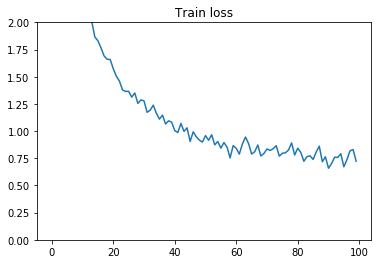

In [8]:
print("Start training...")
t = time()
for i in tqdm.tqdm(range(MAX_ITER)):
    train_pp.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None, drop_last=True, prefetch=0)
print("Training time: {:4.2f} min".format((time() - t)/60))

plt.title('Train loss')
plt.plot(train_pp.get_variable('loss_history'))
plt.ylim((0, 2))
plt.show()

In [9]:
test_template = (Pipeline()
               .load_images()
               .create_multi(image_shape=SHAPE, max_digits=5)
               .import_model('conv', train_pp)
               .init_variable('predicted_proba', init_on_each_run=list)
               .init_variable('predicted_labels', init_on_each_run=list)
               .predict_model('conv', fetches=['predicted_proba', 'predicted_labels'], 
                                       feed_dict={'images': B('images'),
                                                  'masks': B('masks')},
                               save_to=[V('predicted_proba'), V('predicted_labels')], mode='a'))

In [10]:
test_ppl = (test_template << multi_mnist.test)

In [11]:
print("Start testing...")
#for i in range(len(mnist.test.indices) // BATCH_SIZE):
for i in range(2):
    batch = test_ppl.next_batch(10)

Start testing...


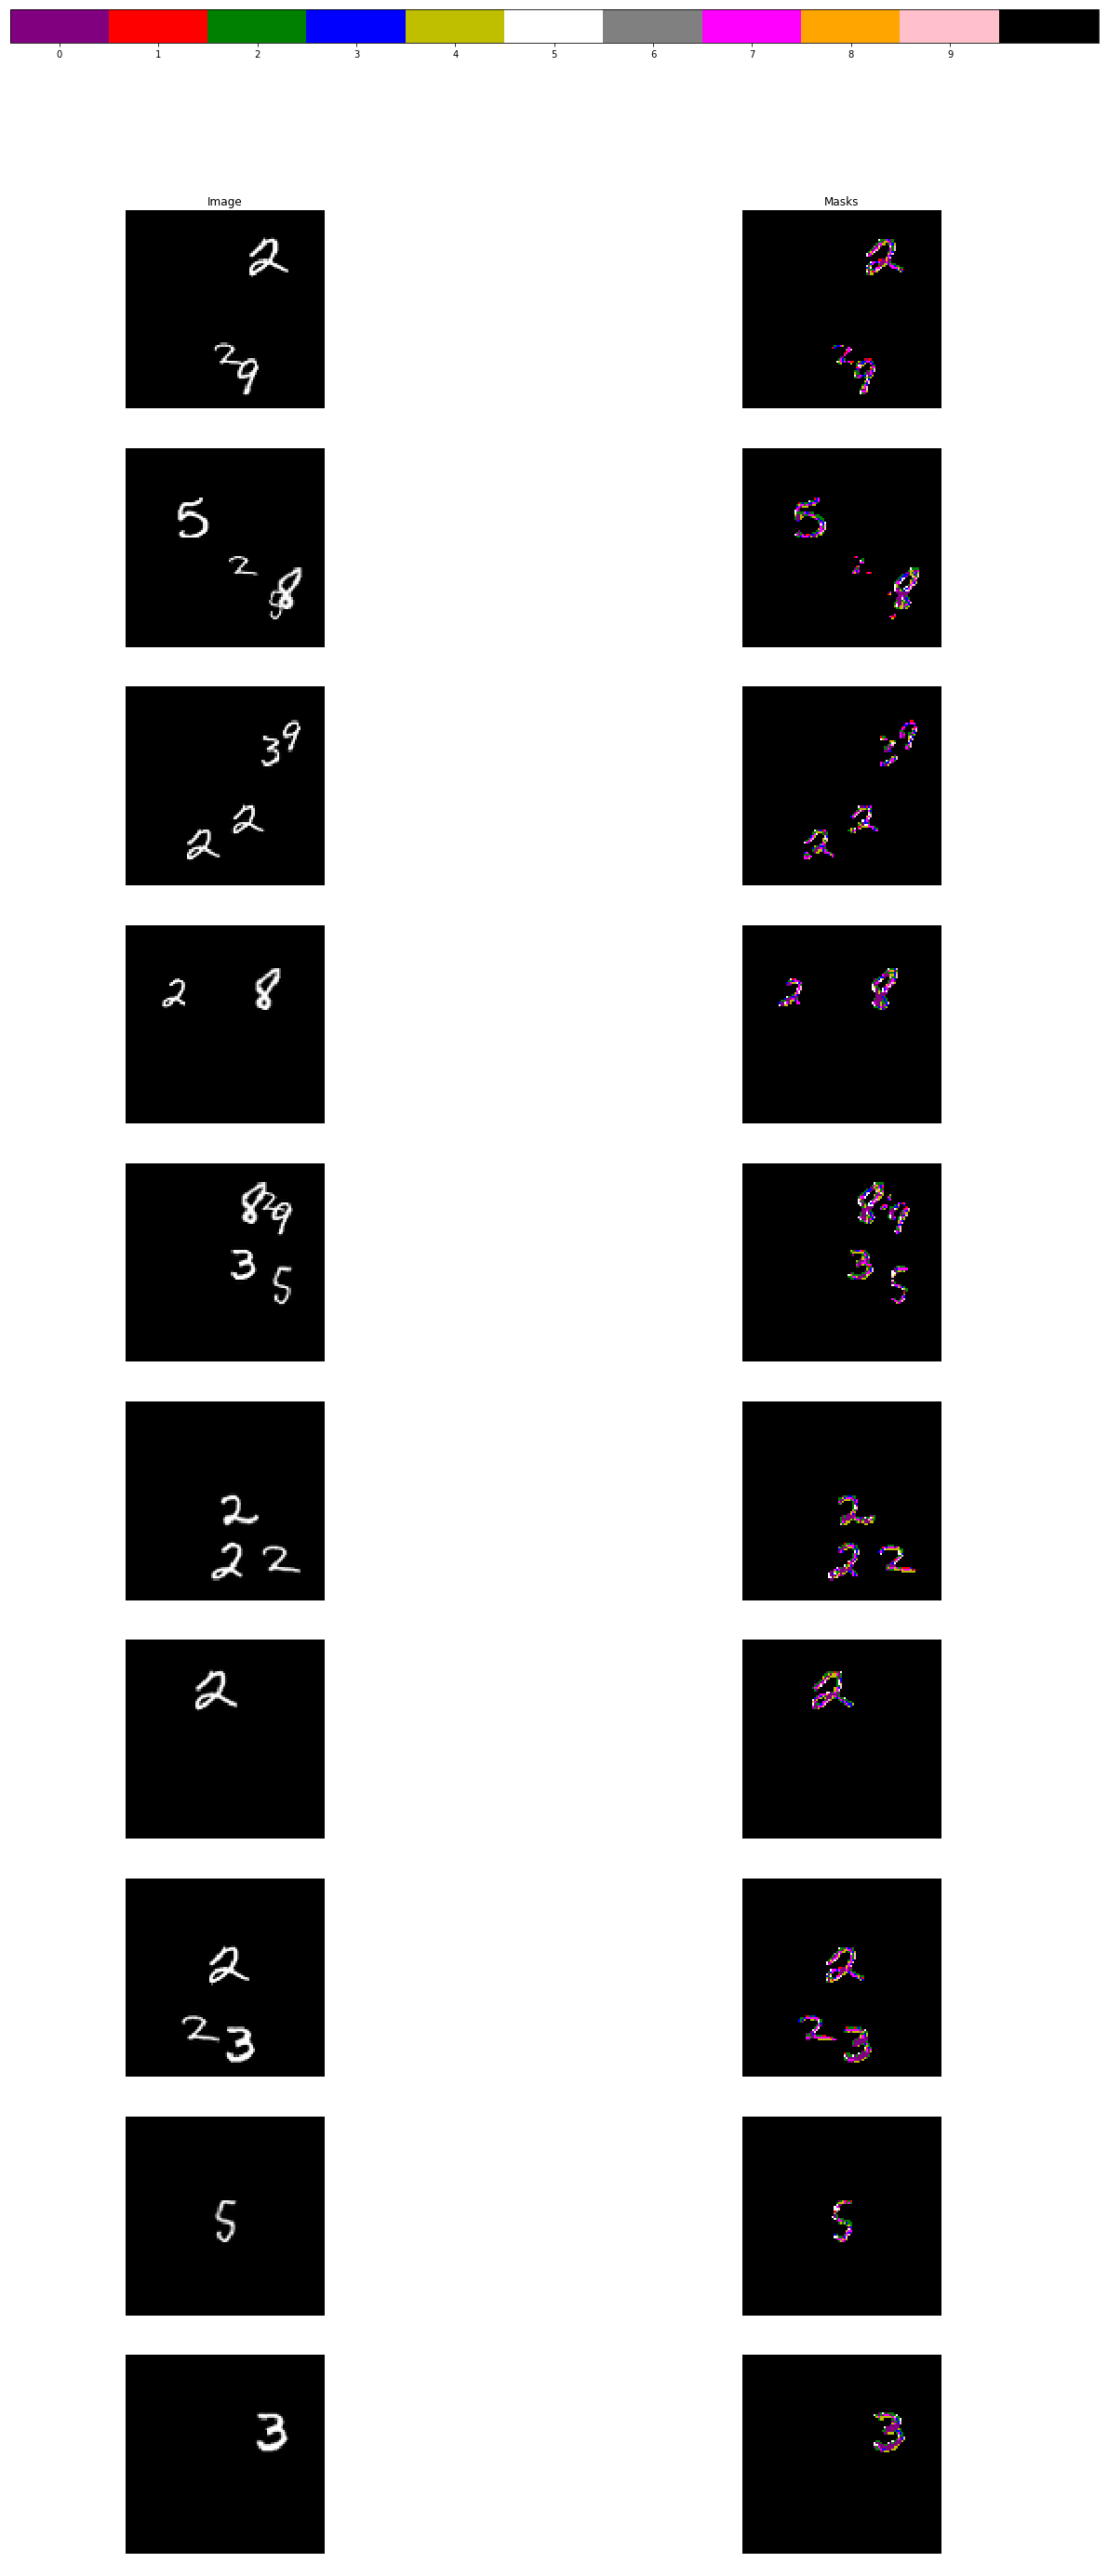

In [12]:
import importlib
import multi_plot
importlib.reload(multi_plot)
multi_plot.get_plots(test_ppl, mode='c', inverse=True)